# Continuous gradients in colorectal tumor

In [1]:
import sys
import os
from collections import defaultdict
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from glmpca import glmpca
from itertools import combinations
import torch

import sys
from importlib import reload

import gaston
from gaston import neural_net,cluster_plotting, dp_related, segmented_fit, restrict_spots
from gaston import binning_and_plotting, isodepth_scaling, run_slurm_scripts, parse_adata
from gaston import spatial_gene_classification, plot_cell_types, filter_genes, process_NN_output

import seaborn as sns
import math

## Step 1: Pre-processing

Here, GASTON takes as input the output of Space Ranger output. In particular the following files are needed: `filtered_feature_bc_matrix.h5` and `spatial/tissue_positions_list.csv`.
Optionally, if one wants to use RGB values as output features, the file `spatial/tissue_hires_image.png`.

In [2]:
!mkdir -p tumor_tutorial_outputs

In [3]:
data_folder='colorectal_tumor_data/'
use_RGB=True # set to False if you do not want to use RGB as features

counts_mat, coords_mat, gene_labels, rgb_mean=parse_adata.get_gaston_input_adata(data_folder, get_rgb=use_RGB, spot_umi_threshold=50)

# save matrices
np.save('colorectal_tumor_data/counts_mat.npy', counts_mat)
np.save('colorectal_tumor_data/coords_mat.npy', coords_mat)
np.save('colorectal_tumor_data/gene_labels.npy', gene_labels)

/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


removing spots with UMI count < 50


/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


calculating RGB


  0%|          | 0/3902 [00:00<?, ?/s]/n/fs/ragr-data/users/uchitra/miniconda3/envs/gaston-package/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
100%|██████████| 3902/3902 [00:13<00:00, 286.72/s]


Compute GLM-PCs (we use 5)

In [ ]:
num_dims=5
penalty=20 # may need to increase if this is too small

glmpca_res=glmpca.glmpca(counts_mat.T, num_dims, fam="poi", penalty=penalty, verbose=True)
A = glmpca_res['factors'] # should be of size N x num_dims, where each column is a PC

if use_RGB:
    A=np.hstack((A,rgb_mean)) # attach to RGB mean
np.save('colorectal_tumor_data/glmpca.npy', A)

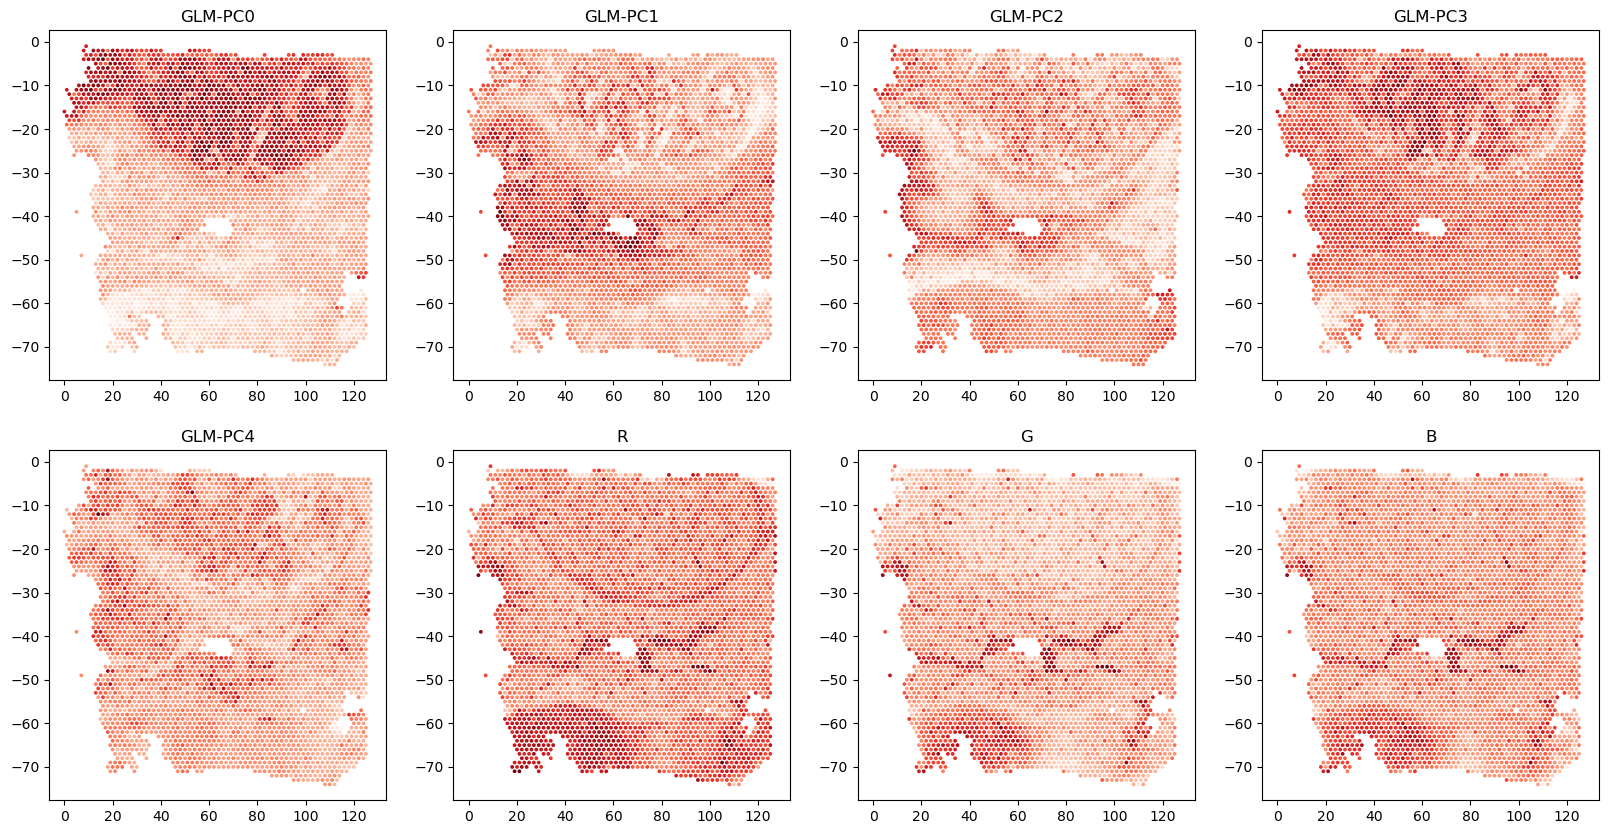

In [9]:
# visualize top GLM-PCs and RGB mean
rotated_coords=dp_related.rotate_by_theta(coords_mat, -np.pi/2)
R=2
C=4
fig,axs=plt.subplots(R,C,figsize=(20,10))
for r in range(R):
    for c in range(C):
        i=r*C+c
        axs[r,c].scatter(rotated_coords[:,0], rotated_coords[:,1], c=A[:,i],cmap='Reds',s=3)
        if i < num_dims:
            axs[r,c].set_title(f'GLM-PC{i}')
        else:
            axs[r,c].set_title('RGB'[i-num_dims])

## Step 2: Train GASTON neural network

We include how to train the neural network with two options: (1) a command line script and (2) in a notebook. We typically train the neural network 30 different times, each with a different seed, and we use the NN with lowest loss. 

### Option 1: Slurm (Recommended)

For option (1), the code below creates 30 different Slurm jobs, one for each initialization. To train the NN for a single initialization run the following command:

`gaston -i /path/to/coords.npy -o /path/to/glmpca.npy -d /path/to/output_dir -e 10000 -c 500 -p 20 20 -x 20 20 -z adam -s SEED`

for a given `SEED` value (integer)

NOTE: please wait for models to finish training before running below code. You can check on their status by running `squeue -u uchitra` (replacing `uchitra` with your username)

In [2]:
# LOAD DATA generated above
# path_to_glmpca='colorectal_tumor_data/glmpca.npy'
# path_to_coords='colorectal_tumor_data/coords_mat.npy'

# To approximately recreate paper figures, use same GLM-PCs from paper 
path_to_glmpca='colorectal_tumor_data/glmpca_from_paper.npy'
path_to_coords='colorectal_tumor_data/coords_from_paper.npy'

# GASTON NN parameters
isodepth_arch=[20,20] # architecture (two hidden layers of size 20) for isodepth neural network d(x,y)
expression_arch=[20,20] # architecture (two hidden layers of size 20) for 1-D expression function
epochs = 10000 # number of epochs to train NN
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
optimizer = "adam"
num_restarts=30 # number of initializations

output_dir='colorectal_tumor_tutorial_outputs' # folder to save model runs

# REPLACE with your own conda environment name and path
conda_environment='gaston-package'
path_to_conda_folder='/n/fs/ragr-data/users/uchitra/miniconda3/bin/activate'

run_slurm_scripts.train_NN_parallel(path_to_coords, path_to_glmpca, isodepth_arch, expression_arch, 
                      output_dir, conda_environment, path_to_conda_folder,
                      epochs=epochs, checkpoint=checkpoint, 
                      num_seeds=num_restarts)

jobId: 19671909
jobId: 19671910
jobId: 19671911
jobId: 19671912
jobId: 19671913
jobId: 19671914
jobId: 19671915
jobId: 19671916
jobId: 19671917
jobId: 19671918
jobId: 19671919
jobId: 19671920
jobId: 19671921
jobId: 19671922
jobId: 19671923
jobId: 19671924
jobId: 19671925
jobId: 19671926
jobId: 19671927
jobId: 19671928
jobId: 19671929
jobId: 19671930
jobId: 19671931
jobId: 19671932
jobId: 19671933
jobId: 19671934
jobId: 19671935
jobId: 19671936
jobId: 19671937
jobId: 19671938


### Option 2: train in notebook

In [ ]:
path_to_glmpca='colorectal_tumor_data/glmpca_from_paper.npy'
path_to_coords='colorectal_tumor_data/coords_from_paper.npy'

A=np.load(path_to_glmpca) # GLM-PCA results used in manuscript
S=np.load(path_to_coords)

# z-score normalize S and A
S_torch, A_torch = neural_net.load_rescale_input_data(S,A)

In [ ]:
######################################
# NEURAL NET PARAMETERS (USER CAN CHANGE)
# architectures are encoded as list, eg [20,20] means two hidden layers of size 20 hidden neurons
isodepth_arch=[20,20] # architecture for isodepth neural network d(x,y) : R^2 -> R 
expression_fn_arch=[20,20] # architecture for 1-D expression function h(w) : R -> R^G

num_epochs = 10000 # number of epochs to train NN (NOTE: it is sometimes beneficial to train longer)
checkpoint = 500 # save model after number of epochs = multiple of checkpoint
out_dir='colorectal_tumor_tutorial_outputs' # folder to save model runs
optimizer = "adam"
num_restarts=30

######################################

seed_list=range(num_restarts)
for seed in seed_list:
    print(f'training neural network for seed {seed}')
    out_dir_seed=f"{out_dir}/rep{seed}"
    os.makedirs(out_dir_seed, exist_ok=True)
    mod, loss_list = neural_net.train(S_torch, A_torch,
                          S_hidden_list=isodepth_arch, A_hidden_list=expression_fn_arch, 
                          epochs=num_epochs, checkpoint=checkpoint, 
                          save_dir=out_dir_seed, optim=optimizer, seed=seed, save_final=True)

## Step 3: Process neural network output

We use the model trained for the paper for reproducibility. If you use the model trained above, then figures will closely match the manuscript --- but not exactly match --- due to PyTorch non-determinism in seeding (see https://github.com/pytorch/pytorch/issues/7068 ). 

In [12]:
# gaston_model, A, S= process_NN_output.process_files('colorectal_tumor_tutorial_outputs') # model trained above
gaston_model, A, S= process_NN_output.process_files('colorectal_tumor_data/reproduce_tumor') # MATCH PAPER FIGURES

# May need to re-load counts_mat, coords_mat, and gene_labels
counts_mat=np.load('colorectal_tumor_data/counts_mat.npy',allow_pickle=True)
coords_mat=np.load('colorectal_tumor_data/coords_mat.npy',allow_pickle=True)
gene_labels=np.load('colorectal_tumor_data/gene_labels.npy',allow_pickle=True)

best model: colorectal_tumor_data/reproduce_tumor/seed23


Compute isodepth and GASTON domains 

In [13]:
num_layers=5
gaston_isodepth, gaston_labels=dp_related.get_isodepth_labels(gaston_model,A,S,num_layers)

# DATASET-SPECIFIC: so domains are ordered oligodendrocyte to molecular, with increasing isodepth
gaston_isodepth= np.max(gaston_isodepth) -1 * gaston_isodepth
gaston_labels=(num_layers-1)-gaston_labels

Plot topographic map: isodepth and spatial gradients

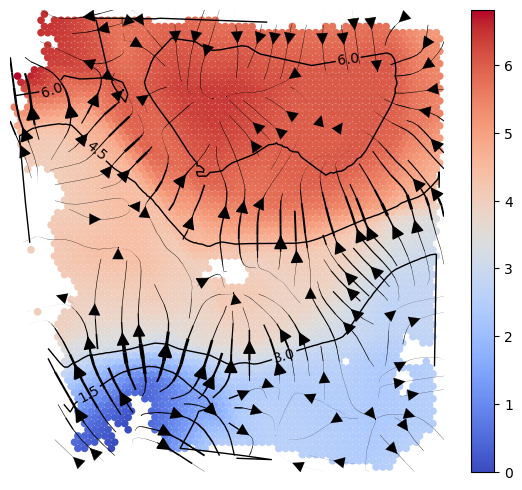

In [24]:
show_streamlines=True
rotate = np.radians(-90) # rotate coordinates by -90
arrowsize=2

cluster_plotting.plot_isodepth(gaston_isodepth, S, gaston_model, figsize=(7,6), streamlines=show_streamlines, 
                               rotate=rotate,arrowsize=arrowsize)

Plot GASTON domains

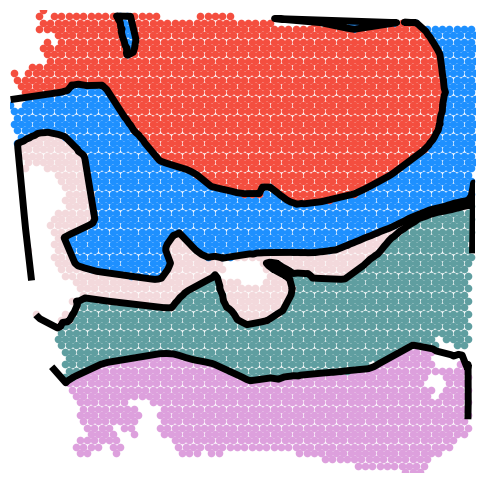

In [15]:
domain_colors=colors=['plum', 'cadetblue', '#F3D9DC','dodgerblue', '#F44E3F']
cluster_plotting.plot_clusters(gaston_labels, S, figsize=(6,6), 
                               colors=domain_colors, s=20, lgd=False, 
                               show_boundary=True, gaston_isodepth=gaston_isodepth, boundary_lw=5, rotate=rotate)

## Continuous gradient analysis

### Restrict to domains 1, 2 of tumor

To isolate the tumor section, we restrict to spots with isodepth lying in a given range. The range of isodepth values will need to be tuned depending on the specific application.

In some cases, the tissue geometry cannot be represented with a single isodepth. In this case, we recommend first subsetting your tissue to the specific region of interest (eg from ScanPy clustering), and then running GASTON

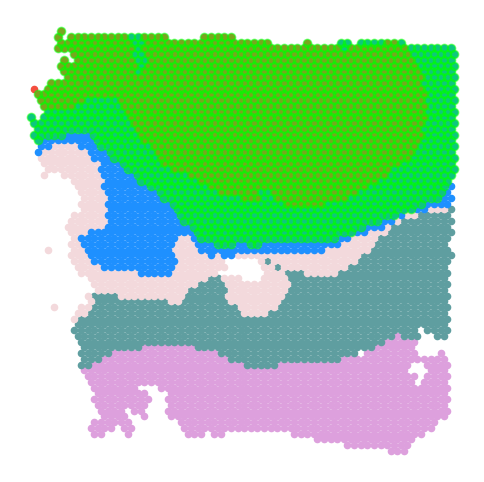

In [25]:
# This is the range we used for reproducing figure papers.
isodepth_min=4.5
isodepth_max=6.8

cluster_plotting.plot_clusters_restrict(gaston_labels, S, gaston_isodepth, 
                                        isodepth_min=isodepth_min, isodepth_max=isodepth_max, figsize=(6,6), 
                                        colors=domain_colors, s=20, lgd=False, rotate=rotate)

Once you have a range that looks reasonable, then we restrict the isodepth, domain labels, coords matrix, and counts matrix to only be for the green spots

restricting to 1792 spots


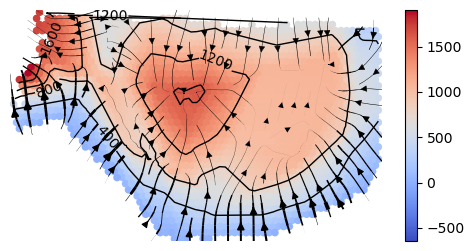

In [29]:
# Optional: adjust isodepth for physical distance
adjust_physical=True
scale_factor=100 # since distance of 1 = 100 microns for 10x Visium

# Optional: plot isodepth for green spots
plot_isodepth=True

# plotting parameters
show_streamlines=True
rotate=np.radians(-90)
arrowsize=1


counts_mat_restrict, coords_mat_restrict, gaston_isodepth_restrict, gaston_labels_restrict=restrict_spots.restrict_spots(
                                                             counts_mat, coords_mat, S, gaston_isodepth, gaston_labels, 
                                                             isodepth_min=isodepth_min, isodepth_max=isodepth_max, 
                                                             adjust_physical=adjust_physical, scale_factor=scale_factor,
                                                             plot_isodepth=plot_isodepth, show_streamlines=show_streamlines, 
                                                             gaston_model=gaston_model, rotate=rotate, figsize=(6,3), 
                                                             arrowsize=arrowsize)


### Compute piecewise linear fits

We restrict to genes with at least 1000 total UMIs, that are not mitochondrial/ribosomal

In [30]:
umi_thresh = 1000
idx_kept, gene_labels_idx=filter_genes.filter_genes(counts_mat, gene_labels, 
                                       umi_threshold=umi_thresh, 
                                       exclude_prefix=['MT-', 'RPL', 'RPS'])

Compute piecewise linear fit over restricted spots from above

In [31]:
# compute piecewise linear fit for restricted spots
pw_fit_dict=segmented_fit.pw_linear_fit(counts_mat_restrict, gaston_labels_restrict, gaston_isodepth_restrict,
                                        None, [],  idx_kept=idx_kept, umi_threshold=umi_thresh, isodepth_mult_factor=0.01,)
# for plotting
binning_output=binning_and_plotting.bin_data(counts_mat2, gaston_labels2, gaston_isodepth2, 
                         None, gene_labels, idx_kept=idx_kept, num_bins=15, umi_threshold=umi_thresh)

Poisson regression for ALL cell types


100%|██████████| 5306/5306 [00:59<00:00, 89.25it/s] 


Find discontinuous and continuous genes

In [33]:
domain_colors=['dodgerblue', '#F44E3F']

discont_genes_layer=spatial_gene_classification.get_discont_genes(pw_fit_dict, binning_output,q=0.95)
cont_genes_layer=spatial_gene_classification.get_cont_genes(pw_fit_dict, binning_output,q=0.8)

Plot gene COX7B from manuscript. This is a Type I gene, with only intratumoral variation as shown below (continuous gradient only in domain 1, ie tumor)

gene COX7B: discontinuous jump after domain(s) []
gene COX7B: continuous gradient in domain(s) [1]


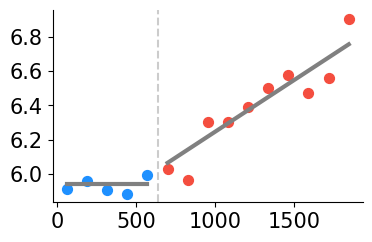

In [34]:
gene_name='COX7B'
print(f'gene {gene_name}: discontinuous jump after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous gradient in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels2, gaston_isodepth2, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

Plot gene SCD from manuscript. This is a Type I gene, with intrastromal and intratumoral variation (continuous gradient in domains 0, 1) but no discontinuity

gene SCD: discontinuous after domain(s) []
gene SCD: continuous in domain(s) [0, 1]


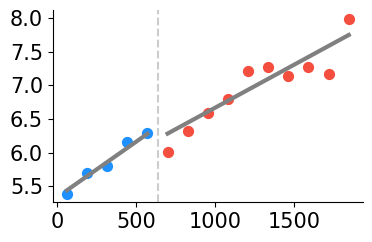

In [35]:
gene_name='SCD'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels2, gaston_isodepth2, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)

Plot gene ACTA2 from manuscript. This is a Type II gene, with both intrastromal variation (gradient in domain 0) and discontinuity

gene ACTA2: discontinuous after domain(s) [0]
gene ACTA2: continuous in domain(s) [0]


(3.0, 5.6)

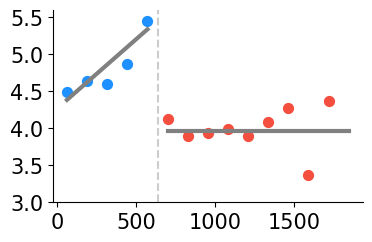

In [36]:
gene_name='ACTA2'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels2, gaston_isodepth2, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((3,5.6))

Plot gene TAGLN from manuscript. This is a Type II gene, with both intrastromal variation (gradient in domain 0) and discontinuity

gene TAGLN: discontinuous after domain(s) [0]
gene TAGLN: continuous in domain(s) [0]


(3.0, 6.2)

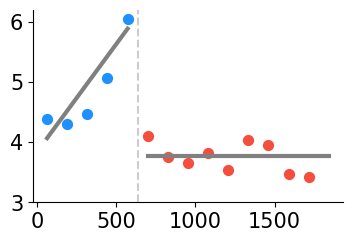

In [37]:
gene_name='TAGLN'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels2, gaston_isodepth2, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((3,6.2))

Plot gene COL1A2 from manuscript. This is a Type II gene, with intrastromal/intratumoral variation and discontinuity

gene COL1A2: discontinuous after domain(s) [0]
gene COL1A2: continuous in domain(s) [0, 1]


(4.0, 6.5)

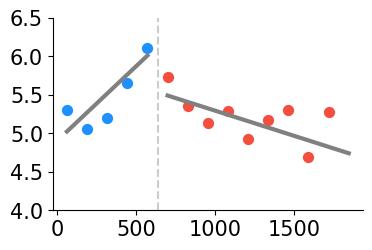

In [259]:
gene_name='COL1A2'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels2, gaston_isodepth2, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((4,6.5))

Plot gene THBS1 from manuscript. This is a Type III gene, with intrastromal variation

gene THBS1: discontinuous after domain(s) [0]
gene THBS1: continuous in domain(s) []


(3.0, 6.0)

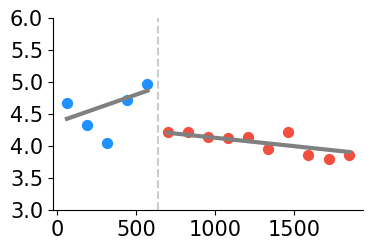

In [40]:
gene_name='THBS1'
print(f'gene {gene_name}: discontinuous after domain(s) {discont_genes_layer[gene_name]}') 
print(f'gene {gene_name}: continuous in domain(s) {cont_genes_layer[gene_name]}')

# display log CPM (if you want to do CP500, set offset=500)
offset=10**6

binning_and_plotting.plot_gene_pwlinear(gene_name, pw_fit_dict, gaston_labels2, gaston_isodepth2, 
                                        binning_output, cell_type_list=None, pt_size=50, colors=domain_colors, 
                                        linear_fit=True, ticksize=15, figsize=(4,2.5), offset=offset, lw=3,
                                       domain_boundary_plotting=True)
plt.ylim((3,6))